<a href="https://colab.research.google.com/github/pscabral/IFMA_Softex/blob/main/teste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/alekswael/fruit_classifier_LR_VGG16

Cloning into 'fruit_classifier_LR_VGG16'...
remote: Enumerating objects: 17839, done.
remote: Counting objects: 100% (876/876), done.
remote: Compressing objects: 100% (857/857), done.
remote: Total 17839 (delta 25), reused 862 (delta 15), pack-reused 16963
Receiving objects: 100% (17839/17839), 79.24 MiB | 29.33 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Updating files: 100% (16871/16871), done.


574710816/574710816 [==============================] - 5s 0us/step


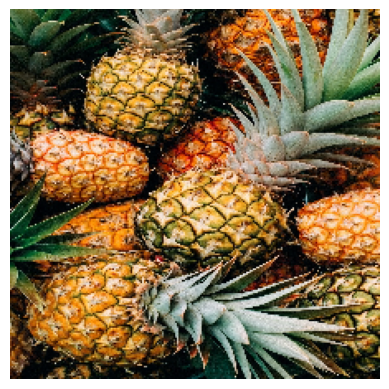

35363/35363 [==============================] - 0s 0us/step
pineapple (100.00%)


In [2]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import decode_predictions
from keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt

# load the model
model = VGG19()

# load an image from file
image = load_img('/content/abacaxi.jpg', target_size=(224, 224))

# Display the image
plt.imshow(image)
plt.axis('off')  # Remove os eixos (bordas) da imagem
plt.show()

# convert the image pixels to a numpy array
image = img_to_array(image)

# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# prepare the image for the VGG model
image = preprocess_input(image)

# predict the probability across all output classes
yhat = model.predict(image)

# convert the probabilities to class labels
label = decode_predictions(yhat)

# retrieve the most likely result, e.g. highest probability
label = label[0][0]

# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

In [ ]:
import os
import numpy as np
from PIL import Image
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Caminhos para diretórios de treinamento e teste
diretorio_treinamento = '/content/fruit_classifier_LR_VGG16/fruits_v2/train'
diretorio_teste = '/content/fruit_classifier_LR_VGG16/fruits_v2/test'

# Função para carregar imagens de um diretório
def carregar_imagens(diretorio):
    X = []
    y = []

    for root, dirs, files in os.walk(diretorio):
        for imagem_nome in files:
            caminho_imagem = os.path.join(root, imagem_nome)
            try:
                img = Image.open(caminho_imagem)
                img = img.resize((224, 224))
                img = np.array(img)
                img = preprocess_input(img)
                X.append(img)
                y.append(os.path.basename(root))  # Subdiretório como rótulo
            except:
                print(f"Erro ao carregar: {caminho_imagem}")

    return X, y

# Carregar imagens de treinamento e teste
X_train, y_train = carregar_imagens(diretorio_treinamento)
X_test, y_test = carregar_imagens(diretorio_teste)

X_train = np.array(X_train)
X_test = np.array(X_test)

# Codificar os rótulos em números
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Carregar o modelo VGG19 pré-treinado com pesos do ImageNet
base_model = VGG19(weights='imagenet', include_top=False)

# Adicionar camadas personalizadas para a tarefa de classificação
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Adicionar regularização de dropout
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar as camadas convolucionais para usar os pesos pré-treinados
for layer in base_model.layers:
    layer.trainable = False

# Compilar o modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Visualizar as curvas de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curvas de Aprendizado')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

# Avaliar o modelo no conjunto de teste
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Acurácia no conjunto de teste: {accuracy * 100:.2f}%')

# Gerar relatório de classificação
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
class_names = label_encoder.classes_
print(classification_report(y_test_encoded, y_pred_classes, target_names=class_names))

# Matriz de confusão
confusion_mtx = confusion_matrix(y_test_encoded, y_pred_classes)
print(confusion_mtx)

# Salvar o modelo treinado
model.save('vgg19_model.h5')

print("Modelo treinado foi salvo com sucesso como 'vgg19_model.h5'")